Вивантажую дані двох csv файлів

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

activity_data = pd.read_csv('ucu_hw_3_activity_data.csv', sep = ',', index_col = 'id')
users_data = pd.read_csv('ucu_hw_3_users_data.csv', sep = ';', index_col = 'id')
activity_data.head(5)

,customer_id,date
id,,
0,100000,2022-02-19
1,100000,2022-02-20
2,100000,2022-02-22
3,100000,2022-02-27
4,100000,2022-03-04


In [3]:
users_data.head(5)

,customer_id,registration,onboarding,completed_profile,is_male,channel,setup date,subscription_date,subscription_type
id,,,,,,,,,
0,100000,1,1,1,1,1,2022-01-08,2022-02-16,basic
1,100002,1,1,1,0,3,2022-01-25,2022-03-08,premium
2,100006,1,1,1,0,3,2022-01-04,2022-02-03,premium
3,100010,1,1,1,0,3,2022-01-27,2022-03-14,basic
4,100015,1,1,0,0,1,2022-01-17,2022-02-24,basic


**1)** Розраховую кількість днів після закінчення тріалу до підписки. Для початку до дати встановлення *setup date* додаю 30 днів, щоб визначити дату закінчення тріалу. Далі цю дату віднімаю від дати підписки *subscription_date*

In [4]:
users_data['setup date'] = pd.to_datetime(users_data['setup date'])
users_data['subscription_date'] = pd.to_datetime(users_data['subscription_date'])

users_data['diff_sub_trial_days'] = (users_data['subscription_date'] - (users_data['setup date'] + pd.Timedelta(days=30))).dt.days
users_data

,customer_id,registration,onboarding,completed_profile,is_male,channel,setup date,subscription_date,subscription_type,diff_sub_trial_days
id,,,,,,,,,,
0,100000,1,1,1,1,1,2022-01-08,2022-02-16,basic,9
1,100002,1,1,1,0,3,2022-01-25,2022-03-08,premium,12
2,100006,1,1,1,0,3,2022-01-04,2022-02-03,premium,0
3,100010,1,1,1,0,3,2022-01-27,2022-03-14,basic,16
4,100015,1,1,0,0,1,2022-01-17,2022-02-24,basic,8
...,...,...,...,...,...,...,...,...,...,...
20368,199975,1,1,1,0,1,2022-01-25,2022-03-01,basic,5
20369,199977,1,1,1,0,3,2022-01-28,2022-02-28,basic,1
20370,199991,1,1,1,0,1,2022-01-28,2022-03-06,basic,7


Збираю та візуалізую статистику за кількістю користувачів у розрізі отриманих днів від закінчення тріалу до покупки підписки

In [5]:
df1 = users_data.groupby('diff_sub_trial_days').agg(
    subscription_customer = ('customer_id', 'count')
).reset_index()

df1['% subscription_customer'] = round((df1['subscription_customer'] / df1['subscription_customer'].sum()) * 100, 2) 
df1

,diff_sub_trial_days,subscription_customer,% subscription_customer
0,0,2995,14.70
1,1,3039,14.92
2,2,1668,8.19
3,3,1598,7.84
4,4,1660,8.15
5,5,1692,8.31
6,6,1684,8.27
7,7,1244,6.11
8,8,269,1.32
9,9,329,1.61


На графіку видно, що великий відсоток клієнтів купують підписку протягом найближчих 2 днів, далі тренд різко йде на спад. Загалом же 75% користувачів купують підписку в перший тиждень

In [6]:
users_data['diff_sub_trial_days'].describe()

count    20373.000000
mean         5.395033
std          5.116370
min          0.000000
25%          1.000000
50%          4.000000
75%          7.000000
max         17.000000
Name: diff_sub_trial_days, dtype: float64

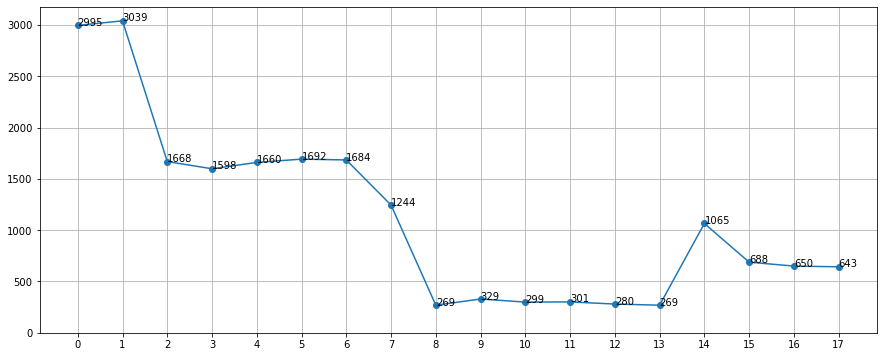

In [7]:
plt.figure(figsize=(15, 6))
x = df1['diff_sub_trial_days'].astype('str')
plt.plot(x, df1['subscription_customer'], marker='o')

for i, value in enumerate(df1['subscription_customer']):
    plt.text(i, value, str(value))

plt.ylim(0)
plt.grid()
plt.show()

**2)** Агоритм аналізу Retention методом когорт з кроком у тиждень:
- звертаюсь до другого дата фрейму, який зберігає дати тренувать користувачів після придбання підписки;
- мержу до кожного клієнту колонку з датою підписки з первого дата фрейму;
- знаходжу порядковий номер кожного тижня, на якому користувач тренувався (дата відліку - дата найпершого тренування);
- знаходжу на якому тижні користувач потренувався в перший раз - рядки майбутньої матриці;
- віднімаю від порядкового номера кожного тренування номер тижня першого тренування клієнта - стовпці матриці.

In [8]:
activity_data = pd.merge(activity_data, users_data[['customer_id', 'subscription_date']], on='customer_id', how='left')
activity_data['date'] = pd.to_datetime(activity_data['date'])
activity_data['diff_day'] = ((activity_data['date'] - activity_data['subscription_date'].min()).dt.days)
activity_data['diff_week'] = ((activity_data['date'] - activity_data['subscription_date'].min()).dt.days / 7).astype(int)
activity_data['min_week'] = activity_data.groupby('customer_id')['diff_week'].transform('min')
activity_data['next_event'] = activity_data['diff_week'] - activity_data['min_week']
activity_data

,customer_id,date,subscription_date,diff_day,diff_week,min_week,next_event
0,100000,2022-02-19,2022-02-16,19,2,2,0
1,100000,2022-02-20,2022-02-16,20,2,2,0
2,100000,2022-02-22,2022-02-16,22,3,2,1
3,100000,2022-02-27,2022-02-16,27,3,2,1
4,100000,2022-03-04,2022-02-16,32,4,2,2
...,...,...,...,...,...,...,...
95363,199999,2022-02-16,2022-02-16,16,2,2,0
95364,199999,2022-02-17,2022-02-16,17,2,2,0
95365,199999,2022-02-21,2022-02-16,21,3,2,1
95366,199999,2022-02-25,2022-02-16,25,3,2,1


Далі рахую дві зведені таблиці (з абсолютними та відносними величинами) та отримую верхньотрикутні матриці, які містять дані про повернення унікальних користувачів із розбивкою на тижні.

В результаті отримую:
* рядки - порядок тижня, на якому клиент придбав підписку (від 2022-01-31)
* колонки - порядок тижня, на якому клиент зайшов у додаток та потренувався (від дати першого тренування юзера - 0 стовпець)

In [9]:
retention_cohort = pd.pivot_table(activity_data, 
                             values='customer_id', 
                             index='min_week', 
                             columns='next_event', 
                             aggfunc='nunique', 
                             margins=True)
retention_cohort

next_event,0,1,2,3,4,5,6,All
min_week,,,,,,,,
0,1508.0,1244.0,1041.0,832.0,829.0,709.0,542.0,1508
1,3645.0,2912.0,2324.0,2075.0,1876.0,1314.0,NaN,3645
2,4260.0,3321.0,2729.0,2380.0,1804.0,NaN,NaN,4260
3,4375.0,3397.0,2774.0,1895.0,NaN,NaN,NaN,4375
4,3593.0,2791.0,1818.0,NaN,NaN,NaN,NaN,3593
5,1790.0,1145.0,NaN,NaN,NaN,NaN,NaN,1790
6,604.0,NaN,NaN,NaN,NaN,NaN,NaN,604
All,19775.0,14810.0,10686.0,7182.0,4509.0,2023.0,542.0,19775


In [10]:
perc_retention_cohort = np.round(retention_cohort.div(retention_cohort['All'], axis=0), 2)
perc_retention_cohort

next_event,0,1,2,3,4,5,6,All
min_week,,,,,,,,
0,1.0,0.82,0.69,0.55,0.55,0.47,0.36,1.0
1,1.0,0.80,0.64,0.57,0.51,0.36,NaN,1.0
2,1.0,0.78,0.64,0.56,0.42,NaN,NaN,1.0
3,1.0,0.78,0.63,0.43,NaN,NaN,NaN,1.0
4,1.0,0.78,0.51,NaN,NaN,NaN,NaN,1.0
5,1.0,0.64,NaN,NaN,NaN,NaN,NaN,1.0
6,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
All,1.0,0.75,0.54,0.36,0.23,0.10,0.03,1.0


**3)** За отриманими даними будую криві повернення з тижневими когортами для абсолютних та відносних величин

За результатами видно, що найкращий стабільний результат щотижневого повернення продемонстрували клієнти, які придбали підписку у додатку в перший тиждень. Однак це невеликий відсоток користувачів від загальної суми нових клієнтів, тому не може характеризувати динаміку всієї вибірки. Наступні тижні займають лідируючі позиції у кількості нових підписаних клієнтів, однак у них стрімкіше падаючий тренд кривої ретеншена. Фінальний тиждень має найменшу кількість нових підписників, що говорить також і про падіння конверсії підписки з часом.

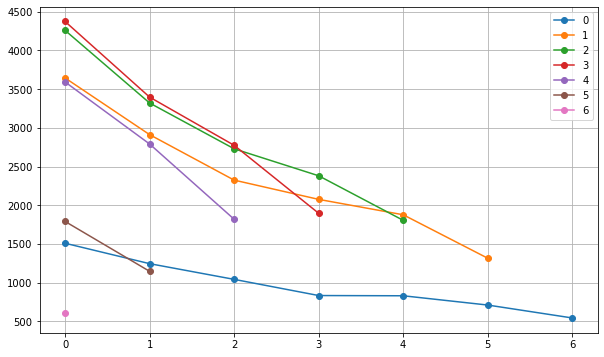

In [11]:
plt.figure(figsize=(10, 6))
retention_cohort_plot = retention_cohort.drop('All', axis=1).drop('All', axis=0)
for index, row in retention_cohort_plot.iterrows():
    plt.plot(retention_cohort_plot.columns, row, label=index, marker='o')

plt.legend()
plt.grid()
plt.show()

Візуалізація відносних даних лише підтверджує лідерство першого тижня з повернень та поступове погіршення статистики повернення кожної тижневої вибірки нових клієнтів з часом.

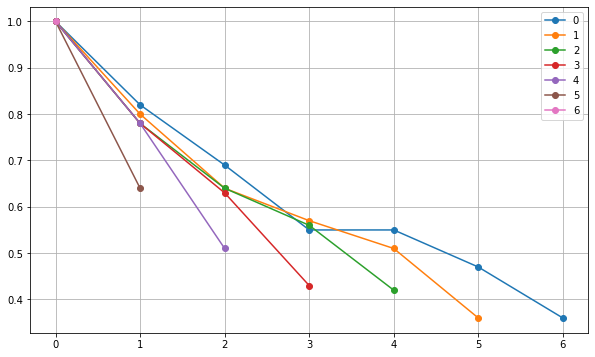

In [12]:
plt.figure(figsize=(10, 6))
perc_retention_cohort_plot = perc_retention_cohort.drop('All', axis=1).drop('All', axis=0)
for index, row in perc_retention_cohort_plot.iterrows():
    plt.plot(perc_retention_cohort_plot.columns, row, label=index, marker='o')

plt.legend()
plt.grid()
plt.show()

**4)** Рахую загальний та середній дохід для цього:
* кожному типу підписки додаю колонку її вартості;
* рахую скільки разів користувач сплатив свій пакет (кількість місяців від 2022-03-19);
* множу кількість оплат підписки (транзакцій) на вартість пакету.

In [13]:
users_data['cost_subsription'] = users_data['subscription_type'].apply(lambda x: 8 if x == 'basic' else 12)
users_data['count_month_subsription'] = ((pd.to_datetime('2022-03-19') - users_data['subscription_date']).dt.days / 30).astype(int) + 1
users_data['revenue'] = users_data['count_month_subsription'] * users_data['cost_subsription']
users_data

,customer_id,registration,onboarding,completed_profile,is_male,channel,setup date,subscription_date,subscription_type,diff_sub_trial_days,cost_subsription,count_month_subsription,revenue
id,,,,,,,,,,,,,
0,100000,1,1,1,1,1,2022-01-08,2022-02-16,basic,9,8,2,16
1,100002,1,1,1,0,3,2022-01-25,2022-03-08,premium,12,12,1,12
2,100006,1,1,1,0,3,2022-01-04,2022-02-03,premium,0,12,2,24
3,100010,1,1,1,0,3,2022-01-27,2022-03-14,basic,16,8,1,8
4,100015,1,1,0,0,1,2022-01-17,2022-02-24,basic,8,8,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20368,199975,1,1,1,0,1,2022-01-25,2022-03-01,basic,5,8,1,8
20369,199977,1,1,1,0,3,2022-01-28,2022-02-28,basic,1,8,1,8
20370,199991,1,1,1,0,1,2022-01-28,2022-03-06,basic,7,8,1,8


Загальний дохід становить 252352$

In [14]:
users_data['revenue'].sum()

252352

Середній дохід на підписанного користувача - 12.39$

In [15]:
round(users_data['revenue'].sum() / users_data['customer_id'].nunique(), 2)

12.39

Агрегую дані в розрізі каналів/мітки онбордингу/статі. Отримані метрики:
* *count_transaction* - кількість оплат пакету підписки
* *subscription_customer* - кількість підписаних унікальних кастомірів
* *revenue* - загальний дохід
* *ARPPU* - середній дохід на підписаного користувача

Середній дохід на підписаного користувача становить у всіх категоріях трьох таблиць приблизно 12.30$, це говорить про те, що лідерство загального доходу однієї з категорій залежить тільки від відсотка підписаних клієнтів. Також зберігається відношення кількості транзакцій на одного користувача (≈ 1.5)

In [16]:
df_revenue_by_channel = users_data.groupby('channel').agg(
    count_transaction = ('count_month_subsription', 'sum'),
    subscription_customer = ('customer_id', 'nunique'),
    revenue = ('revenue', 'sum')
).reset_index()

df_revenue_by_channel['ARPPU'] = np.round(df_revenue_by_channel['revenue'] / df_revenue_by_channel['subscription_customer'], 2)
df_revenue_by_channel

,channel,count_transaction,subscription_customer,revenue,ARPPU
0,1,21322,14393,174732,12.14
1,2,4367,3024,38260,12.65
2,3,4266,2956,39360,13.32


In [17]:
df_revenue_by_onboarding = users_data.groupby('onboarding').agg(
    count_transaction = ('count_month_subsription', 'sum'),
    subscription_customer = ('customer_id', 'nunique'),
    revenue = ('revenue', 'sum')
).reset_index()

df_revenue_by_onboarding['ARPPU'] = np.round(df_revenue_by_onboarding['revenue'] / df_revenue_by_onboarding['subscription_customer'], 2)
df_revenue_by_onboarding

,onboarding,count_transaction,subscription_customer,revenue,ARPPU
0,0,1311,894,11032,12.34
1,1,28644,19479,241320,12.39


In [18]:
df_revenue_by_sex = users_data.groupby('is_male').agg(
    count_transaction = ('count_month_subsription', 'sum'),
    subscription_customer = ('customer_id', 'nunique'),
    revenue = ('revenue', 'sum')
).reset_index()

df_revenue_by_sex['ARPPU'] = np.round(df_revenue_by_sex['revenue'] / df_revenue_by_sex['subscription_customer'], 2)
df_revenue_by_sex

,is_male,count_transaction,subscription_customer,revenue,ARPPU
0,0,26314,17877,221564,12.39
1,1,3641,2496,30788,12.33


**5)** Визначаю прибуток по кожному каналу з урахуванням витрат на залучення
* беру агреговані дані у розрізі каналів на попередньому етапі;
* додаю загальну вартість, витрачену на залучення клієнтів (*channel_cost*) та вартість залучення одного клієнта (*channel_cost_by_customer*);
* віднімаю від *revenue* загальні маркетингові витрати на канал channel_cost та отримую загальну маржу (*general_margin*);
* множу вартість одного клієнта на кількість підписаних клієнтів цього каналу, щоб зрозуміти вартість витрачену на залучення сегменту з підпискою, і віднімаю отримане число від *revenue*, щоб оцінити реальний прибуток від клієнтів (*subscription_margin*).

In [19]:
dict_channel_cost = {1:830000, 2:180000, 3:210000}
dict_channel_cost_by_customer = {1:13.83, 2:8.89, 3:10.63}

df_revenue_by_channel['channel_cost'] = df_revenue_by_channel['channel'].apply(lambda x: dict_channel_cost[x])
df_revenue_by_channel['channel_cost_by_customer'] = df_revenue_by_channel['channel'].apply(lambda x: dict_channel_cost_by_customer[x])
df_revenue_by_channel['general_margin'] = df_revenue_by_channel['revenue'] - df_revenue_by_channel['channel_cost']
df_revenue_by_channel['subscription_margin'] = np.round(df_revenue_by_channel['revenue'] - df_revenue_by_channel['subscription_customer'] * df_revenue_by_channel['channel_cost_by_customer'], 2) 
df_revenue_by_channel

,channel,count_transaction,subscription_customer,revenue,ARPPU,channel_cost,channel_cost_by_customer,general_margin,subscription_margin
0,1,21322,14393,174732,12.14,830000,13.83,-655268,-24323.19
1,2,4367,3024,38260,12.65,180000,8.89,-141740,11376.64
2,3,4266,2956,39360,13.32,210000,10.63,-170640,7937.72


Візуалізую результати.

Раніше у попередній домашній роботі були зроблені висновки про більшу прибутковість першого каналу. Незважаючи на високу вартість залучення одного клієнта, цей канал мав найбільший відсоток конверсії у підписку, який статистично значуще відрізнявся від інших двох каналів. Проте, оцінивши прибуток, який принесли користувачі на цьому каналі, стало очевидним, що це єдиний канал, який пішов у мінус, незважаючи на найбільший відсоток прибутку. За результатами аналізу найбільшу долю від загальної маржі склав 2-й канал із найменшою вартістю залучення.

Якщо ж від отриманого прибутку віднімати всю суму витрат на залучення клієнтів, то стає очевидним, що період функціонування додатку ще не покрив усієї суми витрат на цьому етапі.

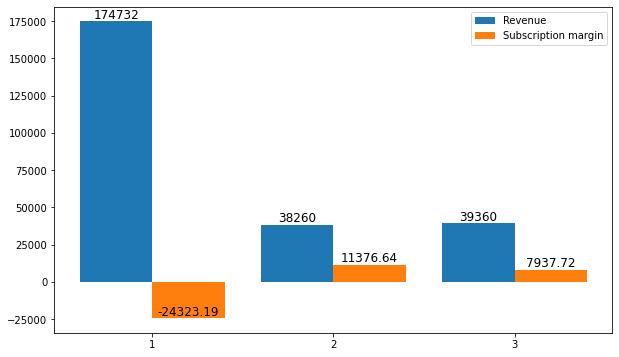

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
x = ['1', '2', '3']

# будую перший барплот
plt.bar(x, df_revenue_by_channel['revenue'], width=0.4, label='Revenue')
# будую другий барплот зі зміщенням
plt.bar([num + 0.4 for num in range(len(x))], df_revenue_by_channel['subscription_margin'], width=0.4, label='Subscription margin')

# задаю крок осі абсцис для відображення каналу посередині двох барів
plt.xticks([num + 0.2 for num in range(len(x))], x)

# додаю значення для обох барплотів
for i, val in enumerate(df_revenue_by_channel['revenue']):
    plt.text(i, val, str(val), ha='center', va='bottom', fontsize=12)

for i, val in enumerate(df_revenue_by_channel['subscription_margin']):
    plt.text(i + 0.4, val, str(val), ha='center', va='bottom', fontsize=12)

plt.grid(False)
plt.legend()
plt.show()

**6)** За перерахованими проміжними результатами та висновками до них очевидно, що ми спостерігаємо падіння прибутку за рахунок великих вкладень у залучення клієнтів. На цьому етапі необхідно сконцентруватися на утриманні користувача:
у збільшенні конверсії у підписку після тріалу та нормалізації падіння ретеншену, який знижується з кожним новим тижнем. Це все призведе до збільшення терміну використання додатку та зростання кількості нових транзакцій з оплати пакетів підписки. Щодо маркетингових витрат, необхідно тимчасово продовжити вкладати бюджет лише у другий канал, для мінімізації витрат. Для покращення customer experience, а отже и retention, необхідно проаналізувати аналогічні продукти на ринку, запровадити періодичну оцінку NPS для отримання великого обсягу зворотного зв'язку клієнтів про їхній досвід взаємодії з цим продуктом, а також провести кілька великих продуктових інтерв'ю з представниками групи всіх персон для отримання інформації про всі болі клієнтів та рекомендацій для визначення подальшого вектора розвитку.
Також рекомендується додатково перевірити ще раз наявність технічних проблем під час використання продукту для виключення такого роду причин падіння показників і сфокусуватися лише на поліпшенні клієнського досвіду використання.